> # モンテカルロ法

確率分布や期待値などを、実際にサンプルモデルを動かして得た結果を積算して求める方法のこと。

In [1]:
# 二つのサイコロの確率分布をサンプルモデルで求める
import numpy as np

def sample(dices=2):
    x = 0
    for _ in range(dices):
        x += np.random.choice([1,2,3,4,5,6])
    return x

In [5]:
trial = 10000

samples = []
for _ in range(trial):
    s = sample()
    samples.append(s)

V = sum(samples) / len(samples) # 平均を求める

print(V)

7.0036


In [9]:
# 毎回平均値を計算する
trial = 10000

samples = []
for i in range(trial):
    s = sample()
    samples.append(s)
    V = sum(samples) / len(samples)
    if i % 1000 == 0:
        print(f"{i}回目の平均値 : {V}")

0回目の平均値 : 9.0
1000回目の平均値 : 6.97002997002997
2000回目の平均値 : 7.043478260869565
3000回目の平均値 : 6.988337220926358
4000回目の平均値 : 6.979755061234691
5000回目の平均値 : 6.965206958608278
6000回目の平均値 : 6.986168971838027
7000回目の平均値 : 6.996714755034995
8000回目の平均値 : 6.992250968628921
9000回目の平均値 : 6.992111987556938


> # （参考） インクリメンタルな方式

平均値を求める計算は、実装上は2通りある。

> ## 一般的な方式

$$
    V_n = \frac{s_1 + s_2 + \cdots + s_n}{n}
$$

> ## インクリメンタルな方式

$$
    V_n = V_{n-1} + \frac{1}{n} (s_n - V_{n-1})
$$

In [13]:
# インクリメンタルな方式で実装
# 2.8秒の実行時間差ができる。

trial = 1000
V, n = 0, 0

for i in range(trial):
    s = sample()
    n += 1
    V += (s - V) /n
    if i % 100 == 0:
        print(f"{i}回目の平均値 : {V}")

0回目の平均値 : 7.0
100回目の平均値 : 6.475247524752473
200回目の平均値 : 6.557213930348259
300回目の平均値 : 6.621262458471757
400回目の平均値 : 6.778054862842886
500回目の平均値 : 6.9101796407185585
600回目の平均値 : 7.003327787021624
700回目の平均値 : 6.995720399429382
800回目の平均値 : 6.992509363295879
900回目の平均値 : 6.942286348501663


> # 5.2 モンテカルロ法による方策評価

> ## 5.2.1 価値関数をモンテカルロ法で見つける

> ## 価値関数の定義

$$
    v_\pi (s) = \mathbf{E}_\pi [G |s]
$$

状態sからスタートして得られる収益を$G$とする。価値関数は、方策$\pi$に従って行動したときに得られる収益の期待値で表される。

> ## モンテカルロ法を用いた価値関数の定義

実際に方策$\pi$に従ってたくさん行動させて、実際の収益（サンプルデータ）を集め、その平均を求める。

$$
    V_\pi (s) = \frac{G^{(1)} + G^{(2)} + \cdots + G^{(n)}}{n}
$$

In [15]:
# GridWorld クラスの実装
# 先ほどの絵の左上が(0, 0)
import numpy as np

class GridWorld:
    def __init__(self):
        # 行動できる方向を指定（4つ）
        self.action_space = [0, 1, 2, 3]
        # 各状態の数字に行動の「意味」をつける
        self.action_meaning = {
            0: 'UP',
            1: 'DOWN',
            2: 'LEFT',
            3: 'RIGHT',
        }
        
        # マップを与える
        self.reward_map = np.array(
            [[0, 0, 0, 1.0],
             [0, None, 0, -1.0],
             [0, 0, 0, 0]]
        )
        
        # 特殊な状態となる場所を定義
        self.goal_state = (0, 3)
        self.wall_state = (1, 1)
        self.start_state = (2, 0)
        
        # エージェントの開始位置
        self.agent_state = self.start_state
        
        
    @property
    def height(self):
        return len(self.reward_map)
        
    @property
    def width(self):
        return len(self.reward_map[0])
        
    @property
    def shape(self):
        return self.reward_map.shape
        
    def actions(self):
        return self.action_space    # [0, 1, 2, 3]
        
    def states(self):
        for h in range(self.height):
            for w in range(self.width):
                yield (h, w)
                
            
    def next_state(self, state, action):
        action_move_map = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        move = action_move_map[action]
        next_state = (state[0] + move[0], state[1] + move[1])
        ny, nx = next_state

        if nx < 0 or nx >= self.width or ny < 0 or ny >= self.height:
            next_state = state
        elif next_state == self.wall_state:
            next_state = state

        return next_state

    def reward(self, state, action, next_state):
        return self.reward_map[next_state]

    def reset(self):
        self.agent_state = self.start_state
        return self.agent_state

    def step(self, action):
        state = self.agent_state
        next_state = self.next_state(state, action)
        reward = self.reward(state, action, next_state)
        done = (next_state == self.goal_state)

        self.agent_state = next_state
        return next_state, reward, done

    def render_v(self, v=None, policy=None, print_value=True):
        renderer = Renderer(self.reward_map, self.goal_state,
                                          self.wall_state)
        renderer.render_v(v, policy, print_value)

    def render_q(self, q=None, print_value=True):
        renderer = Renderer(self.reward_map, self.goal_state,
                                          self.wall_state)
        renderer.render_q(q, print_value)

import numpy as np
import matplotlib
import matplotlib.pyplot as plt


class Renderer:
    def __init__(self, reward_map, goal_state, wall_state):
        self.reward_map = reward_map
        self.goal_state = goal_state
        self.wall_state = wall_state
        self.ys = len(self.reward_map)
        self.xs = len(self.reward_map[0])

        self.ax = None
        self.fig = None
        self.first_flg = True

    def set_figure(self, figsize=None):
        fig = plt.figure(figsize=figsize)
        self.ax = fig.add_subplot(111)
        ax = self.ax
        ax.clear()
        ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
        ax.set_xticks(range(self.xs))
        ax.set_yticks(range(self.ys))
        ax.set_xlim(0, self.xs)
        ax.set_ylim(0, self.ys)
        ax.grid(True)

    def render_v(self, v=None, policy=None, print_value=True):
        self.set_figure()

        ys, xs = self.ys, self.xs
        ax = self.ax

        if v is not None:
            color_list = ['red', 'white', 'green']
            cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
                'colormap_name', color_list)

            # dict -> ndarray
            v_dict = v
            v = np.zeros(self.reward_map.shape)
            for state, value in v_dict.items():
                v[state] = value

            vmax, vmin = v.max(), v.min()
            vmax = max(vmax, abs(vmin))
            vmin = -1 * vmax
            vmax = 1 if vmax < 1 else vmax
            vmin = -1 if vmin > -1 else vmin

            ax.pcolormesh(np.flipud(v), cmap=cmap, vmin=vmin, vmax=vmax)

        for y in range(ys):
            for x in range(xs):
                state = (y, x)
                r = self.reward_map[y, x]
                if r != 0 and r is not None:
                    txt = 'R ' + str(r)
                    if state == self.goal_state:
                        txt = txt + ' (GOAL)'
                    ax.text(x+.1, ys-y-0.9, txt)

                if (v is not None) and state != self.wall_state:
                    if print_value:
                        offsets = [(0.4, -0.15), (-0.15, -0.3)]
                        key = 0
                        if v.shape[0] > 7: key = 1
                        offset = offsets[key]
                        ax.text(x+offset[0], ys-y+offset[1], "{:12.2f}".format(v[y, x]))

                if policy is not None and state != self.wall_state:
                    actions = policy[state]
                    max_actions = [kv[0] for kv in actions.items() if kv[1] == max(actions.values())]

                    arrows = ["↑", "↓", "←", "→"]
                    offsets = [(0, 0.1), (0, -0.1), (-0.1, 0), (0.1, 0)]
                    for action in max_actions:
                        arrow = arrows[action]
                        offset = offsets[action]
                        if state == self.goal_state:
                            continue
                        ax.text(x+0.45+offset[0], ys-y-0.5+offset[1], arrow)

                if state == self.wall_state:
                    ax.add_patch(plt.Rectangle((x,ys-y-1), 1, 1, fc=(0.4, 0.4, 0.4, 1.)))
        plt.show()

    def render_q(self, q, show_greedy_policy=True):
        self.set_figure()

        ys, xs = self.ys, self.xs
        ax = self.ax
        action_space = [0, 1, 2, 3]

        qmax, qmin = max(q.values()), min(q.values())
        qmax = max(qmax, abs(qmin))
        qmin = -1 * qmax
        qmax = 1 if qmax < 1 else qmax
        qmin = -1 if qmin > -1 else qmin


        color_list = ['red', 'white', 'green']
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
            'colormap_name', color_list)

        for y in range(ys):
            for x in range(xs):
                for action in action_space:
                    state = (y, x)
                    r = self.reward_map[y, x]
                    if r != 0 and r is not None:
                        txt = 'R ' + str(r)
                        if state == self.goal_state:
                            txt = txt + ' (GOAL)'
                        ax.text(x+.05, ys-y-0.95, txt)

                    if state == self.goal_state:
                        continue

                    tx, ty = x, ys-y-1

                    action_map = {
                        0: ((0.5+tx, 0.5+ty), (tx+1, ty+1), (tx, ty+1)),
                        1: ((tx, ty), (tx+1, ty), (tx+0.5, ty+0.5)),
                        2: ((tx, ty), (tx+0.5, ty+0.5), (tx, ty+1)),
                        3: ((0.5+tx, 0.5+ty), (tx+1, ty), (tx+1, ty+1)),
                    }
                    offset_map = {
                        0: (0.1, 0.8),
                        1: (0.1, 0.1),
                        2: (-0.2, 0.4),
                        3: (0.4, 0.4),
                    }
                    if state == self.wall_state:
                        ax.add_patch(plt.Rectangle((tx, ty), 1, 1, fc=(0.4, 0.4, 0.4, 1.)))
                    elif state in self.goal_state:
                        ax.add_patch(plt.Rectangle((tx, ty), 1, 1, fc=(0., 1., 0., 1.)))
                    else:

                        tq = q[(state, action)]
                        color_scale = 0.5 + (tq / qmax) / 2  # normalize: 0.0-1.0

                        poly = plt.Polygon(action_map[action],fc=cmap(color_scale))
                        ax.add_patch(poly)

                        offset= offset_map[action]
                        ax.text(tx+offset[0], ty+offset[1], "{:12.2f}".format(tq))
        plt.show()

        if show_greedy_policy:
            policy = {}
            for y in range(self.ys):
                for x in range(self.xs):
                    state = (y, x)
                    qs = [q[state, action] for action in range(4)]  # action_size
                    max_action = np.argmax(qs)
                    probs = {0:0.0, 1:0.0, 2:0.0, 3:0.0}
                    probs[max_action] = 1
                    policy[state] = probs
            self.render_v(None, policy)


> # 5.3 モンテカルロ法の実装

In [16]:
env = GridWorld()

action = 0
next_state, reward, done = env.step(action)

print('next_state :' , next_state)
print('reaward : ', reward)
print('done:', done)

next_state : (1, 0)
reaward :  0
done: False


> # 5.3.2 エージェントクラスの実装

ランダムな方策に従って行動するエージェントをクラスとして実装する

In [19]:
from collections import defaultdict

class RandomAgent:
    def __init__(self):
        self.gamma = 0.9
        self.action_size = 4
        
        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.V = defaultdict(lambda :0)
        self.cnts = defaultdict(lambda: 0)
        self.memory = []
        
    def get_action(self, state):
        action_probs = self.pi[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)
    
    def add(self, state, action, reward):
        data = (state, action, reward)
        self.memory.append(data)
        
    def reset(self):
        self.memory.clear()
    
    def eval(self):
        G = 0
        for data in reversed(self.memory):  # 逆向きにたどる
            state, action, reward = data
            G = self.gamma * G + reward
            self.cnts[state] += 1
            self.V[state] += (G - self.V[state]) / self.cnts[state]

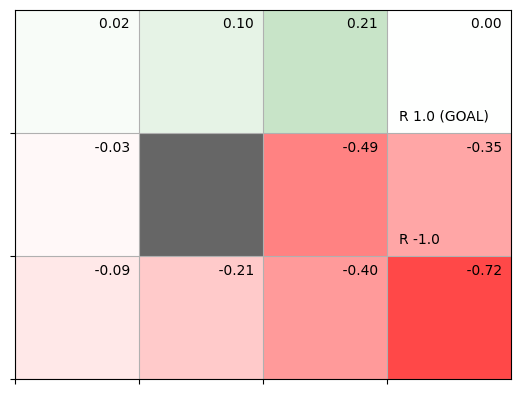

In [20]:
# モンテカルロ法を動かす
env = GridWorld()
agent = RandomAgent()

episodes = 1000
for episode in range(episodes):
    state = env.reset()
    agent.reset()
    
    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)
        
        agent.add(state, action, reward)
        if done:
            agent.eval()
            break
        
        state = next_state
        
env.render_v(agent.V)

> # 5.4 モンテカルロ法による方策制御

> ## 評価と改善

最適な方策$\mu(s)$を得るには、ある状態において、局所的に価値関数が最大となる行動&a$を選べば良い。式にすると、ある状態$s$で行動$a$をとった場合の行動価値関数（Q関数）を$Q(s,a)$として、

$$
    \mu(s) = \argmax_a Q(s, a)
$$

または、

$$
    \mu(s) = \argmax_a \sum_{s'} p(s' |s, a) \bigg\{ r(s, a, s') + \gamma V(s') \bigg\}
$$

> ## 問題点

今までは二つ目の式を使用して価値関数のgreedy化を行ってきた。しかし、この式では状態遷移確率$p(s' |s, a)$と報酬関数$r(s, a, s')$が不明な場合（環境のモデルが不明な場合）方策制御することが不可能である。

そこで、一つ目の式に注目し、Q関数が最大となる行動$a$と取り出す方法を考える。


> # Q関数に対しての評価
Q関数 = 行動$a$が確率的な場合の状態価値関数の求め方と同じ。

$$
    Q_n(s,a) = Q_{n-1} (s,a) + \frac{1}{n} \bigg\{ G^{(n)} - Q_{n-1}(s,a) \bigg\}
$$

> # 5.4.2 モンテカルロ法を使用した方策制御の実装

ポイントは2点

1. 完全なgreedyではなく、$\epsilon$-greedy法を用いる
2. Qの更新は「固定値$\alpha$方式」で行なう。

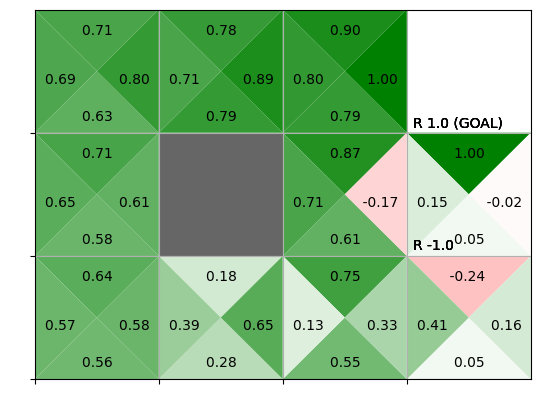

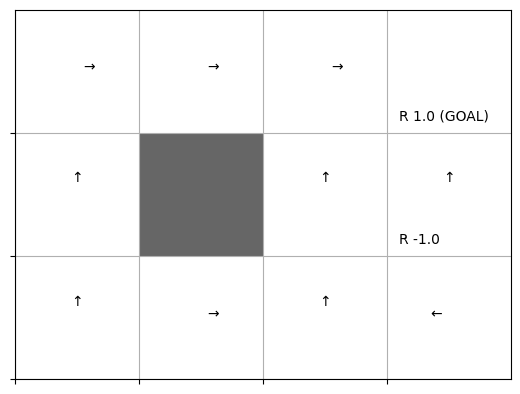

In [29]:
def greedy_probs(Q, state, epsilon=0, action_size=4):
    qs = [Q[(state, action)] for action in range(action_size)]
    max_action = np.argmax(qs)

    base_prob = epsilon / action_size
    action_probs = {action: base_prob for action in range(action_size)}  #{0: ε/4, 1: ε/4, 2: ε/4, 3: ε/4}
    action_probs[max_action] += (1 - epsilon)
    return action_probs


class McAgent:
    def __init__(self):
        self.gamma = 0.9
        self.epsilon = 0.1
        self.alpha = 0.1
        self.action_size = 4

        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.Q = defaultdict(lambda: 0)
        self.memory = []

    def get_action(self, state):
        action_probs = self.pi[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)

    def add(self, state, action, reward):
        data = (state, action, reward)
        self.memory.append(data)

    def reset(self):
        self.memory.clear()

    def update(self):
        G = 0
        for data in reversed(self.memory):
            state, action, reward = data
            G = self.gamma * G + reward
            key = (state, action)
            self.Q[key] += (G - self.Q[key]) * self.alpha
            self.pi[state] = greedy_probs(self.Q, state, self.epsilon)


env = GridWorld()
agent = McAgent()

episodes = 10000
for episode in range(episodes):
    state = env.reset()
    agent.reset()

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.add(state, action, reward)
        if done:
            agent.update()
            break

        state = next_state

env.render_q(agent.Q)

> # 5.5 方策オン型と重点サンプリング

方策オン型 : 評価と改善の対象となる方策「ターゲット方策」とエージェントが実際に行動を起こす際に使う方策「挙動方策」が同じ場合
方策オフ型 : 「ターゲット方策」と「挙動方策」が異なる場合。

**方策オフ型は、他人のスイングを見て自身のスイングを改善する過程に例えられる。**

> ## 方策オフ型を実装するためのテクニック（重点サンプリング）

ある確率分布$\pi(x)$の期待値を、別の確率分布$b(x)$からサンプリングしたデータ$x$を用いて計算する。

少しテクニックを使って期待値の式を変形すると、

$$
    \mathbf{E}_\pi [x] = \sum x \pi(x) = \sum x \frac{\pi(x)}{b(x)}b(x)
$$

つまり、

$$
    \mathbf{E}_\pi [x] = \mathbf{E}_b \bigg[ x\frac{\pi(x)}{b(x)}\bigg]
$$

以後、$\rho(x) := \pi(x) / b(x)$と定義して話を進めることとする。

モンテカルロ法で求めるとき、

$$ 
    \mathbf{E}_\pi [x] = \frac{\rho(x^{(1)})x^{(1)} + \rho(x^{(2)}) x^{(2)} + \cdots + \rho(x^{(n)}) x^{(n)}}{n}
$$

を使用すれば良い。

In [32]:
# 通常のモンテカルロ法を用いて期待値を求める

x = np.array([1,2,3])
pi = np.array([0.1, 0.1, 0.8])

# 期待値
e = np.sum(x * pi)
print('E_pi[x] : ', e)

# モンテカルロ法
n = 100
samples = []
for _ in range(n):
    s = np.random.choice(x, p=pi)
    samples.append(s)

mean = np.mean(samples)
var = np.var(samples)

print(f'MC: {mean} (var: {var})')

E_pi[x] :  2.7
MC: 2.72 (var: 0.4016000000000001)


In [34]:
# 重点サンプリングを用いて期待値を求めた場合
b = np.array([1/3, 1/3, 1/3])
n = 100
samples = []

for _ in range(n):
    idx = np.arange(len(b))     # [0, 1, 2]
    i = np.random.choice(idx, p=b)
    s = x[i]
    rho = pi[i] / b[i]
    samples.append(rho * s)

mean = np.mean(samples)
var = np.var(samples)

print(f'IS: {mean} (var: {var})')

IS: 3.0210000000000012 (var: 10.717659000000008)


> ## 重点サンプリングのポイント
* 二つの確率分布を近づける（Kullback-Liebler情報量を1に近づける分布を選ぶ）ことで分散を少なくし、学習回数を減らすことができる。